# Demonstration of Quantiles fitting + Linear model

This notebook demonstrates the module for an anomaly detection model for solar panels, using a dataset of 9 solar panels in California. This model is based on the following paper: "insert link".

### Library import 

In [7]:
from anomalydetector import MultiDataHandler,OutagePipeline
from anomalydetector import save,load,train_test_split
import pandas as pd
import os
import numpy as np
from scipy.stats import beta
from sklearn.base import BaseEstimator, ClassifierMixin
from pathlib import Path

In [2]:
import solardatatools

### Data loading

We are using a dataset of 9 solar panels situated in California. 

In [19]:
sites = ['01_TAEHC1041562.csv','02_TAEHC1041811.csv','03_ZT164285000441C0745.csv',
         '04_TABF01019463.csv','05_TAEJC1014464.csv','06_TAEHC1024835.csv','07_TAELC1031424.csv',
         '08_ZT161685000441C0867.csv','09_TADBC1076792.csv']
folder_path = Path.cwd().parent.parent / "tests" / "fixtures" / "anomaly_detection"
dfs = {}
for site in sites:
    df = pd.read_csv(folder_path / site)
    dfs[site] = df

As an extension of the DataHandler class, MultiDataHandler class takes into arguement a list of pandas dataframes or a unique dataframe containing all the timeseries and create a MultiDataHandler object ables to run the pipelines for each timeseries and also align/dilate the dataframes.  

In [20]:
dhs = MultiDataHandler(data_frames=list(dfs.values()),datetime_col='measured_on')
#If the DataFrame index does not represent time, specify the name of the column that does.

### Running the pipelines and aligne datasets

The align method runs the pipelines for each DataHandler (if not already done) and computes the list of common valid days.

In [21]:
dhs.align()

Aligning datasets: 100%|██████████| 9/9 [00:00<00:00, 200.36it/s]


The dilate method applies the dilation process to each time series. The result is stored in the object and not returned by the function. If a failure scenario was already computed the function recompute a scenario with default parameters.

In [22]:
dhs.dilate(ndil = 101)

The generate_failure method takes a target as an argument and creates a failure scenario for the given time series. You can also provide a loss distribution in the scipy.stats format (default: uniform distribution), and a proportion_totalday value between 0 and 1, which specifies the proportion of days with a failure lasting the entire day.

In [23]:
example_dist = beta(a = 2, b = 5)
dhs.generate_failure('ac_power_inv_30219',
                     loss_distribution=example_dist,
                     proportion_totalday=0.5)

Finally, you can separate the dataset in a train/test dataset. the first one is used to fit the model while the second one is used to test it.

In [24]:
dh_train,dh_test = train_test_split(dhs,test_size=0.1,shuffle=False)

### OutagePipeline model

The OutagePipeline class contains the model presented in the following paper : "insert link". Firstly, we fit a SmoothPeriodicQuantile model on each timeserie to transform the data in a Gaussian variable. Secondly, we fit a linear regression to predict the target from the other ones. And finally, we classify from the residuals the failure/non-failure scenario.

In [25]:
sites = list(dhs.dil_mat.keys())
ndil = dhs.ndil()
target = dhs.target

The table below shows the default parameter values for the OutagePipeline model, as defined in the original paper.

In [26]:
weight_quantiles = 5
quantiles = np.array([0.02, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 0.98])
solver_quantiles = 'clarabel'
num_harmonics = [30,3]
nlag = 3
num_basis = 8
n_features = (len(sites)-1) * (2*nlag+1) + 1
weight_linear = np.tile(np.arange(1, num_basis+1)**2,n_features)
lambda_range = np.logspace(0, 3, num=10)
num_split = 5
model_residuals = 'ensemble'
train_size = 0.8

In [27]:
model = OutagePipeline(sites,
                ndil,
                target=target,
                solver_quantiles='mosek')

The parameters of the model are attributes of the QLinear object but can be modified within the fitting function. 

#### Fitting

We can fit either all the model all it once, or part by part. 

In [29]:
model.fit_quantiles(dh_train,
                    weight_quantiles = None, #weight for the quantile optimisation
                    quantiles = None, #list of the different quantiles to fit
                    solver_quantiles = None, #solver used in the optimization problem
                    num_harmonics = None, #number of harmoncis per period (so a two elements list) 
                    )

100%|███████████████████████████████████████████| 10/10 [02:57<00:00, 17.73s/it]
c:\Users\coren\Solar-data-tools\environments\ra_dev\Lib\site-packages\spcqe\extrapolate_asymptotic.py:61: RuntimeWarning: invalid value encountered in multiply
  return yasympt + alpha * exp_output
100%|███████████████████████████████████████████| 10/10 [04:16<00:00, 25.61s/it]
c:\Users\coren\Solar-data-tools\environments\ra_dev\Lib\site-packages\spcqe\extrapolate_asymptotic.py:61: RuntimeWarning: invalid value encountered in multiply
  return yasympt + alpha * exp_output
100%|███████████████████████████████████████████| 10/10 [04:12<00:00, 25.29s/it]
c:\Users\coren\Solar-data-tools\environments\ra_dev\Lib\site-packages\spcqe\extrapolate_asymptotic.py:61: RuntimeWarning: invalid value encountered in multiply
  return yasympt + alpha * exp_output


In [30]:
model.fit_linear(nlag = None, #size of the lag to use 
                 num_basis = None, #number of polynoms in the Tchebychev basis 
                 weight_linear = None, #array of weight for the ridge regression
                 lambda_range = None, #range of lambda to try
                 num_split = None #number of split for the KFold 
                 ) 

Residual_model should be an sklearn-compatible model. Most classic models already have implementations in sklearn, 
but if you want to create a custom model, you need to define your own class following the sklearn API.

In [31]:
class MyLogisticClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.01, n_iter=1000):
        self.learning_rate = learning_rate
        self.n_iter = n_iter

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape

        self.weights_ = np.zeros(n_features)
        self.bias_ = 0

        for _ in range(self.n_iter):
            linear_model = X.dot(self.weights_) + self.bias_
            y_pred = self._sigmoid(linear_model)

            dw = (1 / n_samples) * X.T.dot(y_pred - y)
            db = (1 / n_samples) * np.sum(y_pred - y)

            self.weights_ -= self.learning_rate * dw
            self.bias_ -= self.learning_rate * db

        return self

    def predict_proba(self, X):
        X = np.array(X)
        linear_model = X.dot(self.weights_) + self.bias_
        return self._sigmoid(linear_model)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)
    
custom_model = MyLogisticClassifier()

In [32]:
model.fit_residuals(residual_model=custom_model, #model to use for the residual classification
                    train_size=None #proportion of data used for the train set 
                    )


{'accuracy_train': 0.8861454046639232,
 'f1_score_train': 0.8709175738724728,
 'accuracy_val': 0.8743169398907104,
 'f1_score_val': 0.8700564971751412}

In [ ]:
model.fit(dh_train)

100%|███████████████████████████████████████████| 10/10 [03:26<00:00, 20.65s/it]
c:\Users\coren\Solar-data-tools\environments\ra_dev\Lib\site-packages\spcqe\extrapolate_asymptotic.py:61: RuntimeWarning: invalid value encountered in multiply
  return yasympt + alpha * exp_output
100%|███████████████████████████████████████████| 10/10 [03:14<00:00, 19.50s/it]
c:\Users\coren\Solar-data-tools\environments\ra_dev\Lib\site-packages\spcqe\extrapolate_asymptotic.py:61: RuntimeWarning: invalid value encountered in multiply
  return yasympt + alpha * exp_output
100%|███████████████████████████████████████████| 10/10 [03:11<00:00, 19.13s/it]
c:\Users\coren\Solar-data-tools\environments\ra_dev\Lib\site-packages\spcqe\extrapolate_asymptotic.py:61: RuntimeWarning: invalid value encountered in multiply
  return yasympt + alpha * exp_output


{'accuracy_train': 0.896551724137931,
 'f1_score_train': 0.8836565096952909,
 'accuracy_val': 0.8725490196078431,
 'f1_score_val': 0.8686868686868687}

The good way to do it is to fit everything at once the first time, and maybe retrain some part (mostly the last ones) using the pretrain model.

#### Testing

You can test the model with the test method on a new dataset with a failure scenario. 

In [33]:
model.test(dh_test)

{'accuracy_test': 0.8627450980392157, 'f1_score_test': 0.8409090909090909}

#### Predicting

Finally, you can use the predict method on a new dataset.

In [34]:
model.predict(dh_test)

array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

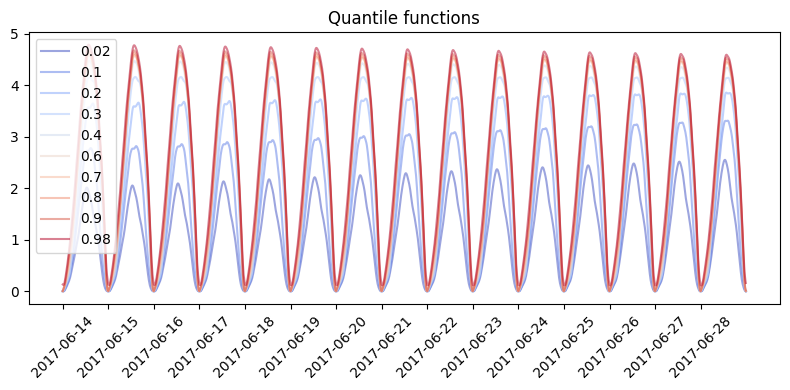

In [35]:
model.display_quantiles(num_day=15,figure='quantile functions')